# Data Science Exploration

#### Import et Connexion Base de donnée Duckdb

In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Connexion
con = duckdb.connect("football.duckdb")

# Sécurité mémoire
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='4GB';")

print("DuckDB ready")

DuckDB ready


In [3]:
con.execute("""
CREATE OR REPLACE VIEW game_tracking AS
SELECT
    player_id,
    session_date,
    time_utc,
    x_pos,
    y_pos,
    speed_kmh
FROM tracking_clean_step2
WHERE session_type = 'game'
AND speed_kmh IS NOT NULL
""")

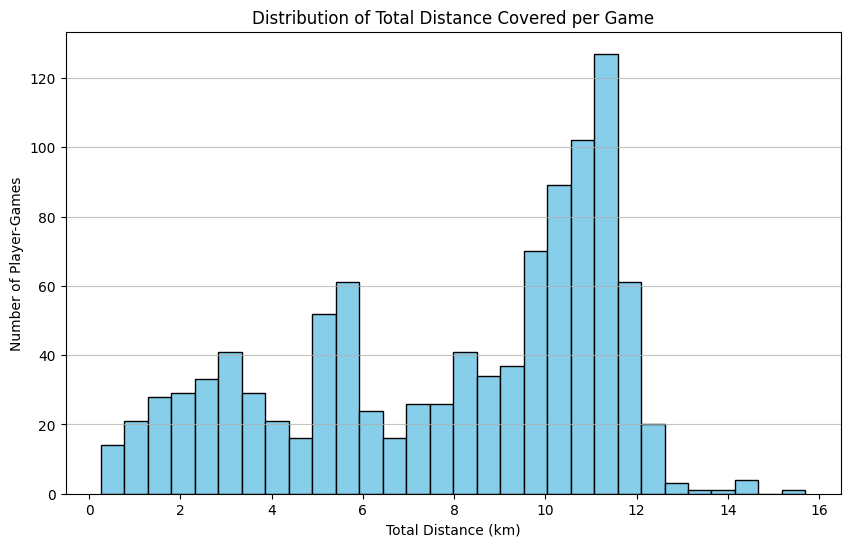

In [4]:
distance_df = con.execute("""
WITH steps AS (
    SELECT
        player_id,
        session_date,
        SQRT(
            POWER(x_pos - LAG(x_pos) OVER w, 2) +
            POWER(y_pos - LAG(y_pos) OVER w, 2)
        ) AS step_dist
    FROM game_tracking
    WINDOW w AS (
        PARTITION BY player_id, session_date
        ORDER BY time_utc
    )
)
SELECT
    player_id,
    session_date,
    SUM(step_dist) AS total_distance_m
FROM steps
GROUP BY player_id, session_date
""").df()

distance_df.head()

# Visualisation
plt.figure(figsize=(10, 6))
plt.hist(distance_df['total_distance_m'] / 1000, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Distance Covered per Game')
plt.xlabel('Total Distance (km)')
plt.ylabel('Number of Player-Games')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [11]:
profile_df = con.execute("""
WITH speed_acc AS (
    SELECT
        player_id,
        time_utc,
        speed_kmh / 3.6 AS speed_ms,
        (speed_kmh / 3.6 -
         LAG(speed_kmh / 3.6) OVER w) /
        EXTRACT(EPOCH FROM (
            time_utc - LAG(time_utc) OVER w
        )) AS acceleration_ms2
    FROM game_tracking
    WINDOW w AS (
        PARTITION BY player_id
        ORDER BY time_utc
    )
)
SELECT *
FROM speed_acc
WHERE acceleration_ms2 IS NOT NULL
""").df()

profile_df.head()

,player_id,time_utc,speed_ms,acceleration_ms2
0,RYDER,2019-09-15 14:00:44.100,0.2856,1.470
1,RYDER,2019-09-15 14:00:44.200,0.4474,1.618
2,RYDER,2019-09-15 14:00:44.300,0.6173,1.699
3,RYDER,2019-09-15 14:00:44.400,0.7780,1.607
4,RYDER,2019-09-15 14:00:44.500,0.9463,1.683


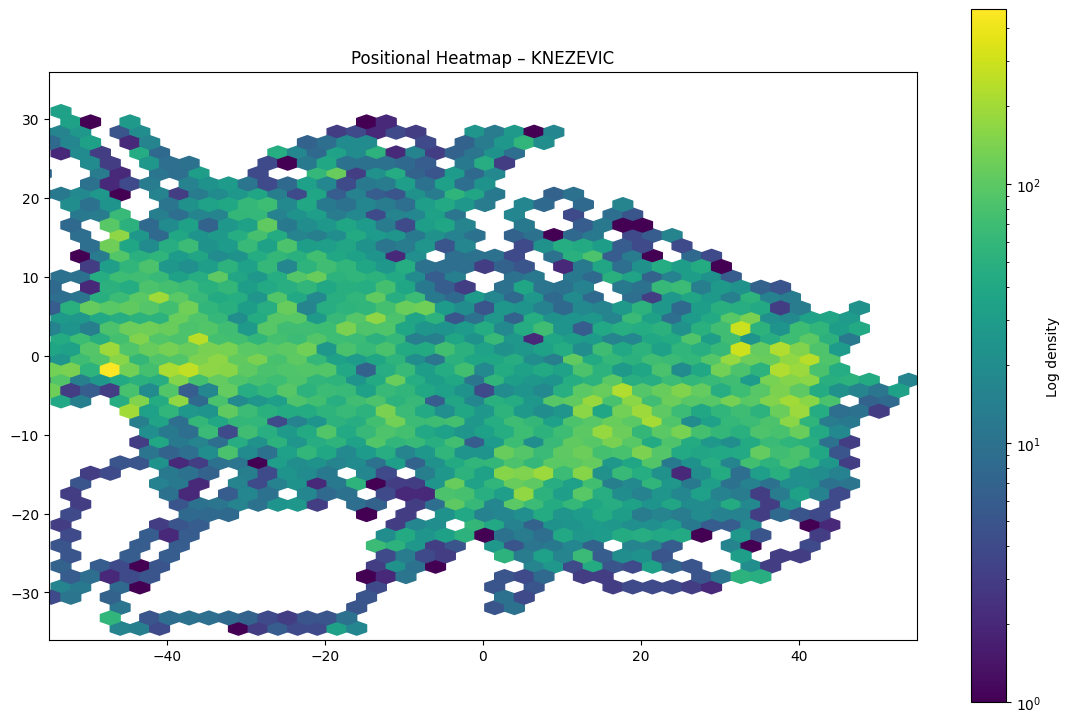

In [13]:
player = "KNEZEVIC"

pos_df = con.execute(f"""
SELECT
    x_pos - 55 AS x,
    y_pos - 36 AS y
FROM game_tracking
WHERE player_id = '{player}'
AND session_date = '2020-02-01'
""").df()

fig, ax = plt.subplots(figsize=(14, 9))

hb = ax.hexbin(
    pos_df['x'],
    pos_df['y'],
    gridsize=45,
    bins='log',   # très important scientifiquement
)

ax.set_title(f"Positional Heatmap – {player}")
ax.set_xlim(-55, 55)
ax.set_ylim(-36, 36)
ax.set_aspect('equal')

plt.colorbar(hb, ax=ax, label='Log density')
plt.show()

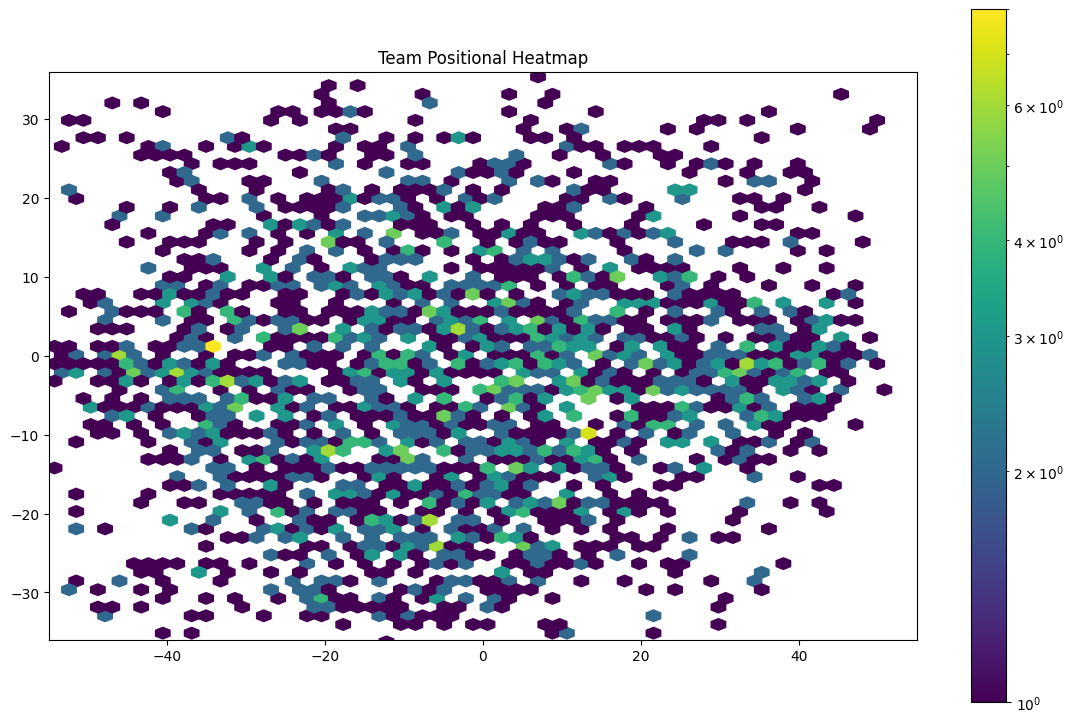

In [14]:
team_df = con.execute("""
SELECT
    x_pos - 55 AS x,
    y_pos - 36 AS y
FROM game_tracking
WHERE session_date = '2020-02-01'
USING SAMPLE 200000 ROWS
""").df()
fig, ax = plt.subplots(figsize=(14, 9))

hb = ax.hexbin(
    team_df['x'],
    team_df['y'],
    gridsize=60,
    bins='log'
)

ax.set_title("Team Positional Heatmap")
ax.set_xlim(-55, 55)
ax.set_ylim(-36, 36)
ax.set_aspect('equal')

plt.colorbar(hb, ax=ax)
plt.show()